In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils_py.io.gro import read_gro, write_gro
from src.utils_py.gro.Structure import Structure
from circle_fit import taubinSVD

In [200]:
structure = read_gro(f'data/cal_dw_568_6248.gro')

In [203]:
max, min = 0, structure.box[2]
half_H = structure.box[2] / 2
for a in structure.atoms:
    if a.mol_name in ['CCaa', 'CCa', 'Oca']:
        if a.xyz[2] < half_H and a.xyz[2] > max:
            max = a.xyz[2]
        elif a.xyz[2] > half_H and a.xyz[2] < min:
            min = a.xyz[2]
print(max, min)

2.154 6.057


In [164]:
atoms_xyz = structure.get_XYZ(mol_names=['DECAN'])

(20860, 3)

In [28]:
os.system(f'./mixer -f server_gromos_droplet.gro -o server_gromos_droplet.gro')

0

In [25]:
with open(f'server_gromos_droplet.gro', 'w') as f:
    f.write(write_gro(structure))

In [149]:
def density(structure, type, N, axis=0):
    # N = np.array([100, 150, 100])
    # structure = read_gro(file).apply_pbc()
    structure_copy = structure.copy()
    grid = np.zeros(N)
    half_box = structure_copy.box / 2
    dr = structure_copy.box / N

    for a in structure_copy.atoms:
        a.xyz += half_box
        if (a.mol_name == type):
            id = np.floor(a.xyz / dr).astype(int)
            id -= (id == N)

            grid[id[0], id[1], id[2]] += 1

    return np.sum(grid, axis=0), dr[(2-axis)//2:(7-axis)//2:(axis%2)+1]

In [4]:
def get_center_pbc(structure, type=None):
    # structure = read_gro(file).apply_pbc()
    atoms_xyz = structure.get_XYZ(mol_names=type)
    theta = atoms_xyz / structure.box * 2 * np.pi
    center = np.zeros(3)

    for i in range(3):
        phi = np.cos(theta[:, i])
        psi = np.sin(theta[:, i])

        phi_mean = np.average(phi)
        psi_mean = np.average(psi)

        theta_mean = np.arctan2(-psi_mean, -phi_mean) + np.pi
        center[i] = structure.box[i] * theta_mean / 2 / np.pi

    return center

In [55]:
def get_border(grid, min=3, max=7):
    border = np.zeros_like(grid).astype(bool)
    shape = grid.shape

    for (i, j) in np.ndindex((shape[0]-2, shape[1]-2)):
        # neigh = (grid[i-1, j+1] > 0) + (grid[i, j+1] > 0) + (grid[i+1, j+1] > 0) + \
        #         (grid[i-1, j] > 0)   +                    + (grid[i+1, j] > 0) + \
        #         (grid[i-1, j-1] > 0) + (grid[i, j-1] > 0) + (grid[i+1, j-1] > 0)

        neigh_list = [grid[i-1, j+1], grid[i, j+1], grid[i+1, j+1], grid[i-1, j], grid[i+1, j], grid[i-1, j-1], grid[i, j-1], grid[i+1, j-1]]
        neigh = sum(map(lambda x: int(x > 0), neigh_list))
        if min < neigh < max:
            border[i, j] = 1
    
    return border

In [63]:
def get_points_from_border(border):
    points = list()

    for (i, j) in np.ndindex(border.shape):
        if border[i, j]:
            points.append(np.array([i, j]))
    
    return np.array(points)

In [166]:
def grid2xyz(grid, dr, box):
    points = list()
    for (i, j) in np.ndindex(grid.shape):
        if grid[i, j]:
            points.append((np.array([i, j]) + 0.5) * dr)
    
    return np.array(points) - box / 2

In [179]:
def points2xyz(points_grid, dr, box):
    points = np.zeros_like(points_grid, dtype=np.float64)
    for i in range(points_grid.shape[0]):
        points[i, :] = (points_grid[i, :] + 0.5) * dr
    
    return points - box / 2

14.509340825992627 14.460300381244819 9.221847615490882 0.7129320727524208


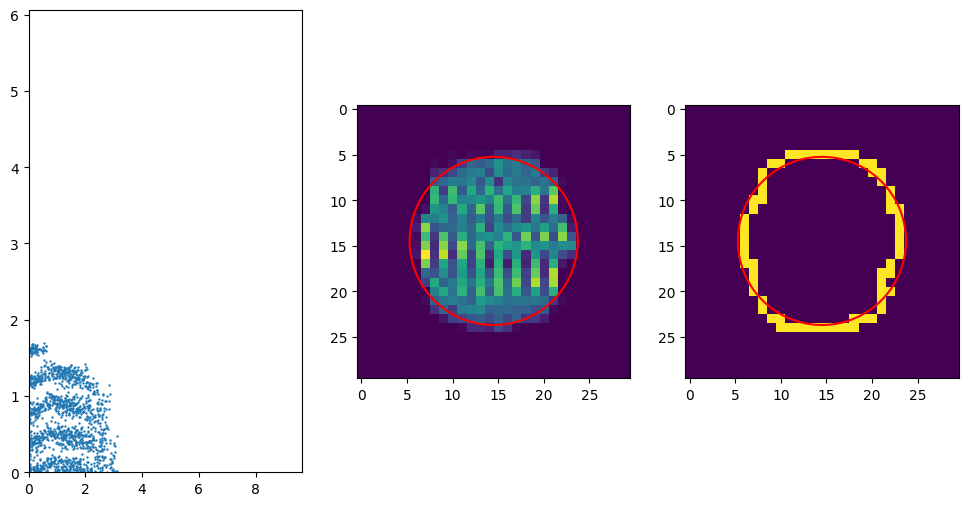

In [170]:
# N = np.ones(3, dtype=int) * 25
structure = read_gro('data/cal_dw_568_6248.gro').apply_pbc()
num = 30
N = np.array([1, num, num])

center = get_center_pbc(structure, type='DECAN')
half_box = structure.box / 2
for a in structure.atoms:
    a.xyz -= center
    a.xyz += half_box
structure = structure.apply_pbc()
for a in structure.atoms:
    a.xyz -= half_box

grid, dr = density(structure, 'DECAN', N)
border = get_border(grid, min=3, max=7)
points = get_points_from_border(border)
xc, yc, r, sigma = taubinSVD(points)
print(xc, yc, r, sigma)

atoms_xyz = structure.get_XYZ(mol_names='DECAN')
# plt.figure(figsize=(8, 6))

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].scatter(atoms_xyz[:, 1], atoms_xyz[:, 2], s=0.5)
ax[0].set_xlim(0, structure.box[1])
ax[0].set_ylim(0, structure.box[2])
ax[1].imshow(grid)
ax[2].imshow(border)
angle = np.linspace(0, 2*np.pi, 100)
ax[1].plot(xc + r * np.cos(angle), yc + r * np.sin(angle), color='red')
ax[2].plot(xc + r * np.cos(angle), yc + r * np.sin(angle), color='red')

[0.24095 0.15145]
-1.2634025171445828 0.04997909541941105 1.704314709571746 0.1564805065900439
1.2936428780921403 0.004355911759523668 1.7060708610601008 0.1517266136868208


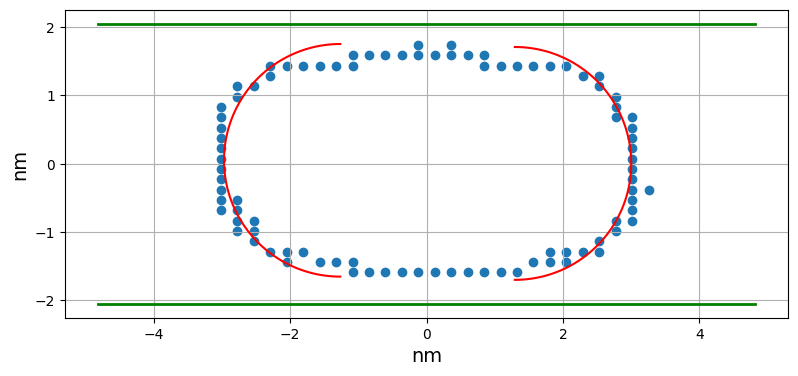

In [204]:
structure = read_gro('data/cal_dw_568_6248.gro').apply_pbc()
num = 40
N = np.array([1, num, num])

center = get_center_pbc(structure, type='DECAN')
half_box = structure.box / 2
for a in structure.atoms:
    a.xyz -= center
    a.xyz += half_box
structure = structure.apply_pbc()
for a in structure.atoms:
    a.xyz -= half_box

grid, dr = density(structure, 'DECAN', N)
print(dr)
border = get_border(grid, min=3, max=7)
grid_points = get_points_from_border(border)
points = points2xyz(grid_points, dr, structure.box[1:])

left_points, right_points = [], []
for i in range(points.shape[0]):
    if points[i, 0] > 0:
        right_points.append(points[i, :])
    else:
        left_points.append(points[i, :])
left_points = np.array(left_points)
right_points = np.array(right_points)

# print(points)
xlc, ylc, rl, sigmal = taubinSVD(left_points)
print(xlc, ylc, rl, sigmal)
xrc, yrc, rr, sigmar = taubinSVD(right_points)
print(xrc, yrc, rr, sigmar)

atoms_xyz = structure.get_XYZ(mol_names='DECAN')
half_H = (6.057 - 2.154) / 2 + 0.1

plt.figure(figsize=(15, 4))
ax = plt.gca()
ax.set_aspect(1)
plt.grid()
plt.xlabel('nm', fontsize=14)
plt.ylabel('nm', fontsize=14)
plt.plot([-half_box[1], half_box[1]], [-half_H, -half_H], linewidth=2, color='green')
plt.plot([-half_box[1], half_box[1]], [half_H, half_H], linewidth=2, color='green')

# plt.scatter(atoms_xyz[:, 1], atoms_xyz[:, 2], s=0.5)
plt.scatter(points[:, 0], points[:, 1])
angle_l = np.linspace(np.pi/2, 3*np.pi/2, 100)
angle_r = np.linspace(3*np.pi/2, 5*np.pi/2, 100)
plt.plot(xlc + rl * np.cos(angle_l), ylc + rl * np.sin(angle_l), color='red')
plt.plot(xrc + rr * np.cos(angle_r), yrc + rr * np.sin(angle_r), color='red')

In [ ]:
# atoms_xyz = structure.get_XYZ(mol_names='DECAN')
# plt.figure(figsize=(8, 6))
# plt.scatter(atoms_xyz[:, 1], atoms_xyz[:, 2], s=0.5)
# # plt.scatter(center[1], center[2])
# plt.scatter(half_box[1], half_box[2])
# plt.xlim(0, structure.box[1])
# plt.ylim(0, structure.box[2])

In [78]:
def get_center(grid, N):
    xv, yv = np.meshgrid(np.arange(N[0]), np.arange(N[1]))

    return np.sum(np.sum(grid * [xv, yv], axis=1), axis=1) / np.sum(grid)

In [79]:
def get_center(file, type=None):
    structure = read_gro(file).apply_pbc()
    atoms_xyz = structure.get_XYZ(mol_names=type)
    return np.average(atoms_xyz, axis=0)

(0.0, 6.058)

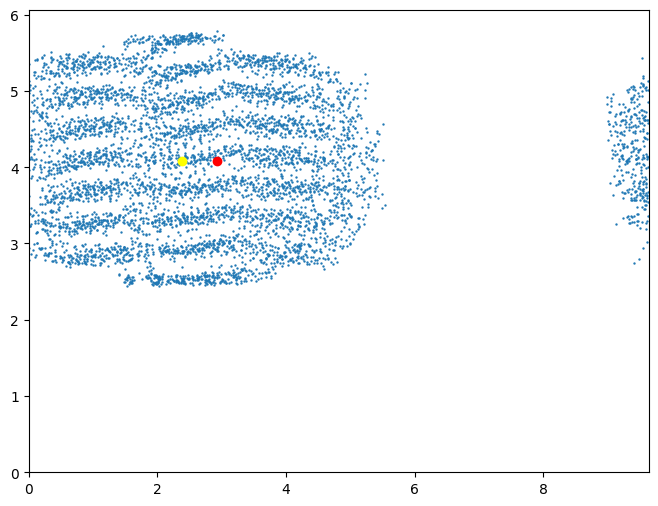

In [80]:
N = np.array([100, 100, 100])
structure = read_gro('data/cal_dw_568_6248.gro').apply_pbc()
grid, dr = density(structure, 'DECAN', N)
atoms_xyz = structure.get_XYZ(mol_names='DECAN')

plt.figure(figsize=(8, 6))
plt.scatter(atoms_xyz[:, 1], atoms_xyz[:, 2], s=0.5)
center = get_center('data/cal_dw_568_6248.gro', type='DECAN')
center_pbc = get_center_pbc(structure, type='DECAN')

plt.scatter(center[1], center[2], color='red')
plt.scatter(center_pbc[1], center_pbc[2], color='yellow')
plt.xlim(0, structure.box[1])
plt.ylim(0, structure.box[2])


In [ ]:
CCaa =	3840
OCaa =	11520
Caa	 =  3840

Caa_charge = 1.6689
CCaa_charge = 0.9989
OCaa_charge = -0.889

print(np.float32(Caa_charge*Caa + CCaa_charge*CCaa + OCaa_charge*OCaa))

charge = np.float32(-(Caa_charge*Caa + CCaa_charge*CCaa) / OCaa)
print(charge)

print(np.float32(Caa_charge*Caa + CCaa_charge*CCaa + charge*OCaa))

3.072
-0.88926667
-3.5522462e-05


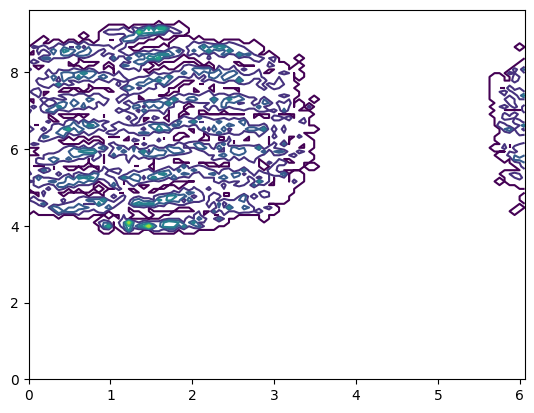

In [224]:
N = np.array([100, 100, 100])
grid, l, dr = density('data/cal_dw_568_6248.gro', 'DECAN', N)
structure = read_gro('data/cal_dw_568_6248.gro').apply_pbc()
atoms_xyz = structure.get_XYZ(mol_names='DECAN')

x = np.linspace(0, structure.box[1], N[1])
y = np.linspace(0, structure.box[2], N[2])
X, Y = np.meshgrid(x, y)
plt.contour(Y, X, grid)

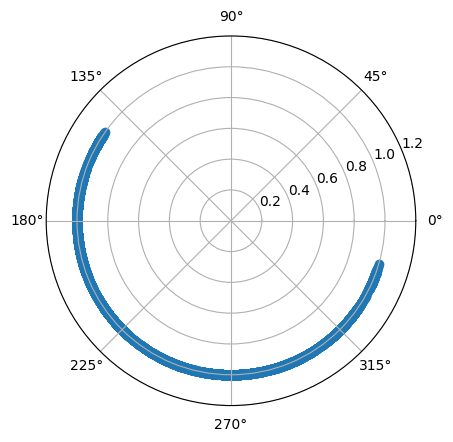

In [216]:
structure = read_gro('data/cal_dw_568_6248.gro').apply_pbc()
atoms_xyz = structure.get_XYZ(mol_names='DECAN')
theta = atoms_xyz / structure.box * 2 * np.pi

axis = 2
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(theta[:, axis], np.ones_like(theta[:, axis]), color='tab:blue')
ax.set_rmax(1.2)
ax.grid(True)

plt.show()

---

In [33]:
os.system(f'scp mipt-nd:alexey/droplet_silica_gromos/sil_wd_178_595.gro data/sil_wd_178_595.gro')
os.system(f'scp mipt-nd:alexey/droplet_silica_gromos/sil_wd_178_595.xtc data/sil_wd_178_595.xtc')
os.system(f'scp mipt-nd:alexey/droplet_silica_gromos/sil_wd_178_595.tpr data/sil_wd_178_595.tpr')
os.system(f'scp mipt-nd:alexey/droplet_silica_gromos/sil_wd_178_595.edr data/sil_wd_178_595.edr')

0

In [192]:
os.system(f'echo 2 3 4 | gmx density -f data/cal_dw_568_6248 -s data/cal_dw_568_6248 -o data/density -d Z -sl 50 -dens number -ng 3')
os.system(f'rm data/#*#')

Selected 2: 'CCaa'
Selected 3: 'OCaa'
Selected 4: 'Caa'


                  :-) GROMACS - gmx density, 2023-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2023/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2023
Working dir:  /Users/alexey/Dev/MD_conf
Command line:
  gmx density -f data/cal_dw_568_6248 -s data/cal_dw_568_6248 -o data/density -d Z -sl 50 -dens number -ng 3

Reading file data/cal_dw_568_6248.tpr, VERSION 2019.2 (single precision)

Select 3 groups to calculate density for:
Group     0 (         System) has 43624 elements
Group     1 (          Other) has 43624 elements
Group     2 (           CCaa) has  3840 elements
Group     3 (           OCaa) has 11520 elements
Group     4 (            Caa) has  3840 elements
Group     5 (          DECAN) has  5680 elements
Group     6 (          WATER) has 18744 elements
Last frame         -1 time 6266.200    a group: 

Read 1 frames from trajectory. Calculating density

Back Off! I just backed up data/density.xvg to data/#density.xvg.1#

GROMACS reminds you: "Ti

0

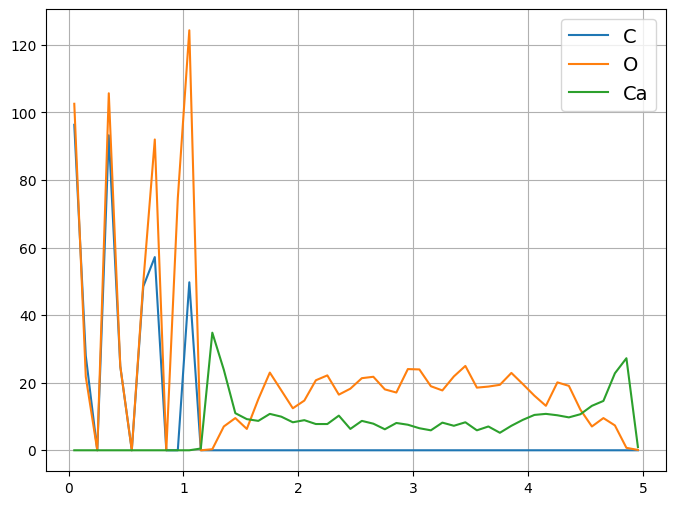

In [199]:
y, dens_CCaa, dens_OCaa, dens_Caa = np.loadtxt("data/density.xvg",comments=["@", "#"],unpack=True)
plt.figure(figsize=(8, 6))
plt.grid()
# ax = plt.gca()
# ax.set_aspect(1)
plt.plot(y, dens_CCaa, label='C')
plt.plot(y, dens_OCaa, label='O')
plt.plot(y, dens_Caa, label='Ca')
plt.legend(fontsize=14)
# plt.plot(y, dens_Caa + dens_OCaa + dens_Caa)
# plt.ylim(bottom=3)


In [126]:
dens[::-1][2]

0.414361

In [127]:
y[::-1][2]

4.94441

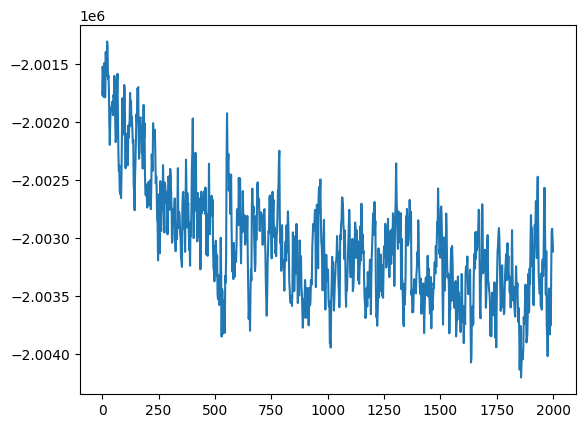

In [43]:
y, eng = np.loadtxt("data/energy.xvg",comments=["@", "#"],unpack=True)
plt.plot(y, eng)

1001
500
250
125
62
31
15
7
3
1


/var/folders/jx/xrzz7g5x5g582hdxfxg7fb680000gn/T/ipykernel_11219/2618020363.py:14: RuntimeWarning: invalid value encountered in scalar divide
  std.append(np.var(eng) / (len(eng) - 1))
/Users/alexey/Dev/MD_conf/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/alexey/Dev/MD_conf/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/alexey/Dev/MD_conf/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


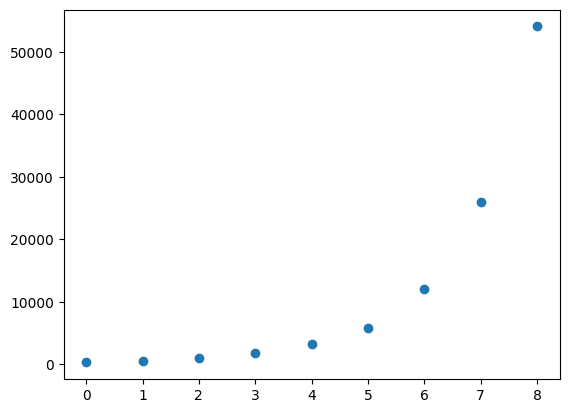

In [42]:
y, eng = np.loadtxt("data/energy.xvg",comments=["@", "#"],unpack=True)

def reduce(arr):
    size = min(arr[0::2].shape[0], arr[1::2].shape[0])
    return (arr[0:2*size:2] + arr[1:2*size:2]) / 2

n = [0]
std = [np.var(eng) / (len(eng) - 1)]
# std = [(np.mean(energy**2) - np.mean(energy)**2) / (len(energy) - 1)]
for i in range(1, 11):
    print(len(eng))
    n.append(i)
    eng = reduce(eng)
    std.append(np.var(eng) / (len(eng) - 1))
    # std.append((np.mean(energy**2) - np.mean(energy)**2) / (len(energy) - 1))

plt.scatter(x=n, y=std)